In [1]:
# Import libraries
import pandas as pd
import os
import time
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

# Import scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Import PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms

In [2]:
# Load the csv
df = pd.read_csv('D:\\EECE\\trainLabels.csv')

# Add the full image path
df['image_path'] = df['image'].apply(lambda x: os.path.join('D:\\EECE\\diabetic-retinopathy-detection\\train', x + '.jpeg'))

# Verify image files
df = df[df['image_path'].apply(lambda x: os.path.exists(x))]
df.head()

,image,level,image_path
0,10_left,0,D:\EECE\diabetic-retinopathy-detection\train\1...
1,10_right,0,D:\EECE\diabetic-retinopathy-detection\train\1...
2,13_left,0,D:\EECE\diabetic-retinopathy-detection\train\1...
3,13_right,0,D:\EECE\diabetic-retinopathy-detection\train\1...
4,15_left,1,D:\EECE\diabetic-retinopathy-detection\train\1...


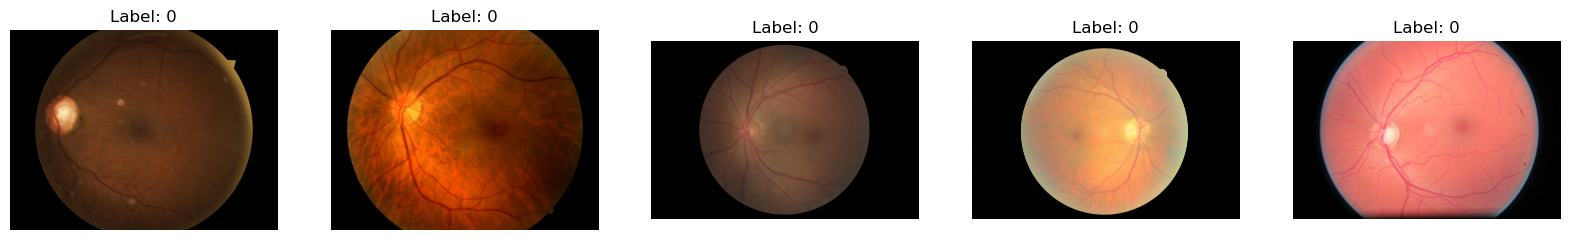

In [3]:
# Randomly select 5 images
sampled_images = df.sample(5)

# Plot each image with its label
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, (index, row) in zip(axes, sampled_images.iterrows()):
    image_path = row['image_path']
    if os.path.exists(image_path):
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Label: {row['level']}")

plt.show()

In [4]:
# Remove rows where 'level' column is either 1 or 2
df = df[~df['level'].isin([1, 2,])]

# Convert 'level' to binary string: 0 stays 0, anything else becomes 1
df['level'] = df['level'].apply(lambda x: 1 if x != 0 else 0)
df["level" ] = df["level"].apply(lambda x: str(x))

# Resample the dataset (this doesnt actually do anything, but it's here for reference)
df = pd.concat([
    df[df['level'] == '0'].sample(25810),
    df[df['level'] == '1'].sample(1581)
]).reset_index(drop=True)

# Verify the new distribution
print(df["level"].value_counts())

0    25810
1     1581
Name: level, dtype: int64


In [5]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

In [6]:
# Create dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_directory, transform):
        self.dataframe = dataframe
        self.image_directory = image_directory
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, index):
        img_name = os.path.join(self.image_directory, self.dataframe.iloc[index, 0] + '.jpeg')
        image = self.transform(Image.open(img_name))
        label = int(self.dataframe.iloc[index, 1])
        return image, label

In [7]:
# Split the DataFrame into training and validation sets
training_df, validation_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [8]:
# Load datasets
training_dataset = CustomDataset(dataframe = training_df, image_directory = 'D:\\EECE\\diabetic-retinopathy-detection\\train', transform = transform)
validation_dataset = CustomDataset(dataframe = validation_df, image_directory = 'D:\\EECE\\diabetic-retinopathy-detection\\train', transform = transform)

# Create DataLoaders
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32)

In [9]:
# Load VGG16
vgg_model = models.vgg16(pretrained=True)

# Unfreeze the layers
for layer in vgg_model.parameters():
    layer.requires_grad = True

# Modify the classifier
vgg_model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 1),
    nn.Sigmoid()
)

# Force CPU
device = torch.device("cpu")
vgg_model.to(device)
print(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(vgg_model.classifier.parameters(), lr=0.001)

C:\Users\jenni\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\jenni\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu


In [10]:
# Train the model
def train_model(model, training_loader, validation_loader, criterion, optimizer, num_epochs):
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_labels = []
        train_predictions = []

        progress_bar = tqdm(training_loader, desc = f"Epoch {epoch+1}/{num_epochs}")
        for inputs, labels in progress_bar:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Store training labels and predictions for AUC calculation
            train_labels.extend(labels.cpu().numpy())
            train_predictions.extend(outputs.detach().cpu().numpy())

        # Calculate AUC for training set
        train_auc = roc_auc_score(train_labels, train_predictions)

        # Start of the validation phase
        model.eval()
        val_loss = 0.0
        val_labels = []
        val_predictions = []

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.float().unsqueeze(1))
                val_loss += loss.item()

                # Store validation labels and predictions for AUC calculation
                val_labels.extend(labels.cpu().numpy())
                val_predictions.extend(outputs.cpu().numpy())

        # Calculate AUC for validation set
        val_auc = roc_auc_score(val_labels, val_predictions)

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(training_loader)}, Training AUC: {train_auc}, Validation Loss: {val_loss / len(validation_loader)}, Validation AUC: {val_auc}")
        # Open the results.txt file and append the results
        with open('results.txt', 'a') as file:
            file.write(f"Epoch {epoch+1}, Loss: {running_loss / len(training_loader)}, Training AUC: {train_auc}, Validation Loss: {val_loss / len(validation_loader)}, Validation AUC: {val_auc}, running_time: {time.time() - start_time}\n")
    # Calculate the runtime
    end_time = time.time()
    print(f"Training completed in {end_time - start_time} seconds")

In [11]:
# Train the model
train_model(vgg_model, training_loader, validation_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50:   1%|▋                                                                   | 7/685 [01:52<3:01:07, 16.03s/it]


KeyboardInterrupt: 